In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from codes.plot_utils import plot_pretty, plot_line_points
plot_pretty(fontsize=12)

k, Pk = np.loadtxt('data/test_matterpower_logintk1000.dat', usecols=(0, 1),  unpack=True)
lk, lPk = np.log10(k), np.log10(Pk)

## Task 1a

In [6]:
def poly_approx(xtr, ftr, xt, method='interpolation', poly_order=1):
    ntr = np.size(ftr)
    
    if method == "interpolation":
        V = np.vander(xtr, N=ntr, increasing=True)
        a = np.linalg.solve(V, ftr)
    elif method == "regression":
        V = np.vander(xtr, N=poly_order, increasing=True)
        a = np.linalg.lstsq(V, ftr, rcond=None)[0]

    pfit = np.poly1d(a[::-1])
    ft = pfit(xt)
    
    return ft, a

In [7]:
xmin, xmax, ntr = 0., 2.*np.pi, 20
xtr = np.linspace(xmin, xmax, ntr)
ftr_int = np.sin(xtr)
# this vector is sine function + a little bit of Gaussian random noise (so mimics approximating noisy data)
ftr_fit = np.sin(xtr) + np.random.normal(scale=0.05, size=np.size(xtr))

nt = 1000 # should be different from nt
xt = np.linspace(xmin, xmax, nt)

poly_int, a_int = poly_approx(xtr, ftr_int, xt, method='interpolation')

poly_order=17
poly_fit, a_fit = poly_approx(xtr, ftr_fit, xt, method='regression', poly_order=poly_order)

#### Plot results:

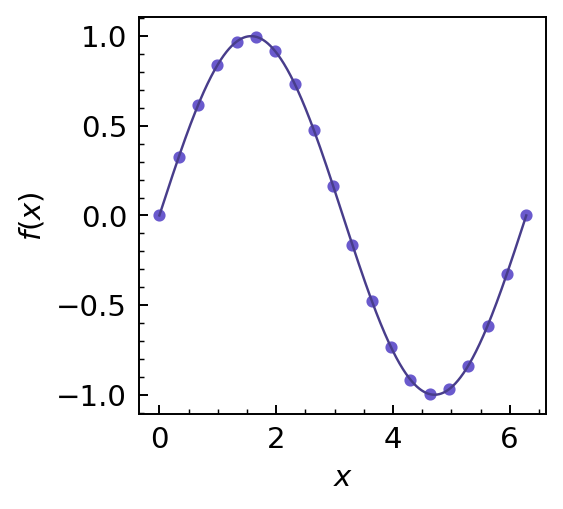

In [8]:
plot_line_points(xt, poly_int, xp=xtr, yp=ftr_int, points=True,
                 xlabel=r'$x$', ylabel=r'$f(x)$', figsize=3)

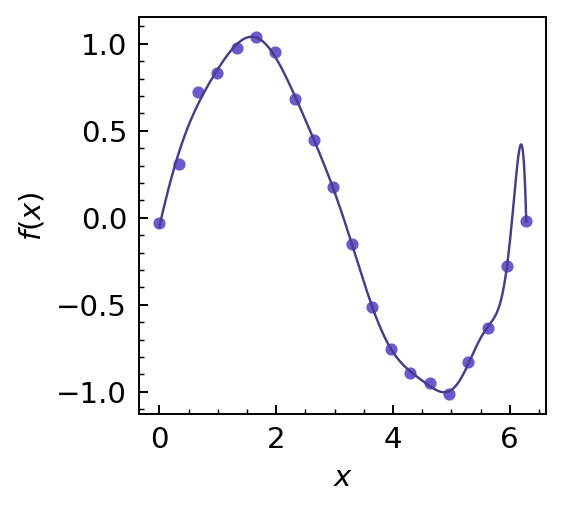

In [9]:
plot_line_points(xt, poly_fit, xp=xtr, yp=ftr_fit, points=True,
                 xlabel=r'$x$', ylabel=r'$f(x)$', figsize=3)

## Task 1b

In [10]:
nkt = 1000
kt = np.linspace(k.min(), k.max(), nkt)

In [11]:
poly_int, a_int = poly_approx(lk, lPk, kt, method='regression', poly_order=np.size(kt))

LinAlgError: SVD did not converge in Linear Least Squares

In [12]:
print(a_int, np.size(a_int))

[ 0.00000000e+00  1.00000000e+00  2.10565825e-09 -1.66666676e-01
  2.45919224e-08  8.33329088e-03  5.18571209e-08 -1.98459424e-04
  3.18978048e-08  2.73895137e-06  6.86986162e-09 -2.72487001e-08
  5.47102044e-10  5.55130258e-11  1.52383075e-11 -2.36673694e-12
  1.11861168e-13 -1.14511490e-15 -5.06586598e-17  8.57852229e-19] 20


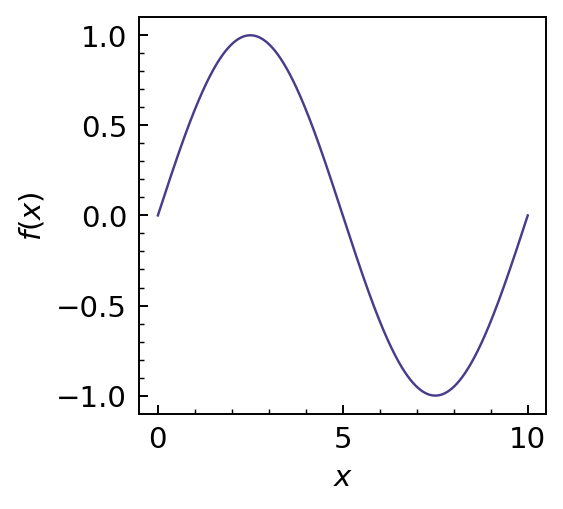

In [13]:
plot_line_points(kt, poly_int, xlabel=r'$x$', ylabel=r'$f(x)$', figsize=3)

In [14]:
lkt = np.linspace(lk.min(), lk.max(), nkt)
poly_intl, a_intl = poly_approx(lk, lPk, lkt, method='interpolation')

In [15]:
poly_int, a_int = poly_approx(lk, lPk, lkt, method='regression', poly_order=20)

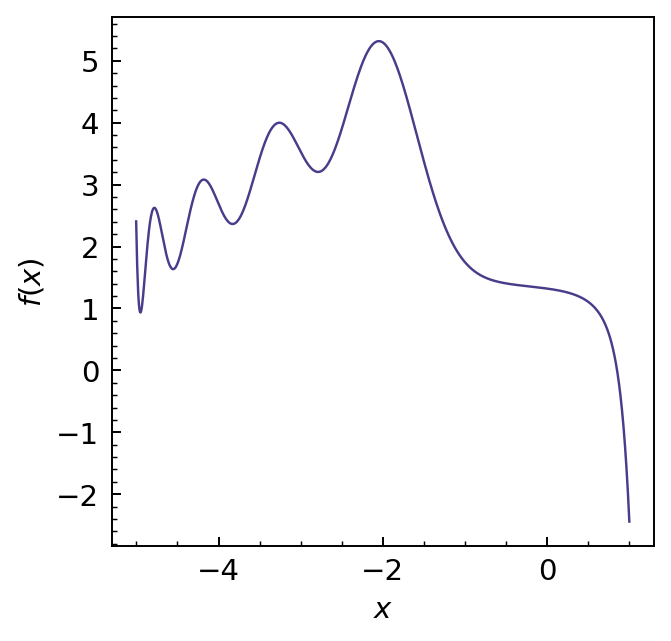

In [16]:
plot_line_points(lkt, poly_int, xlabel=r'$x$', ylabel=r'$f(x)$', figsize=4)